<a href="https://colab.research.google.com/github/HSE-LAMBDA/MLatFIAN2021/blob/main/seminar11/MLatFIAN2021_seminar11_AutoencodersAndSemiSupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder example

In this example we'll show how an auto-encoder can help when labeled data is limited. Will take the MNIST data keeping only the labels of first 300 examples (out of 60000).

In [113]:
import numpy as np

import tensorflow as tf
tf.__version__

'2.7.0'

Load and preprocess the data (as numpy arrays):

In [114]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = (X_train / 255).astype('float32')
X_test  = (X_test  / 255).astype('float32')

Basic autoencoder architecture:

In [116]:
ll = tf.keras.layers
activation = tf.nn.relu

encoder = tf.keras.Sequential([
    ll.Reshape((28, 28, 1), input_shape=(28, 28)),

    ll.Conv2D(16, 3, padding='same', activation=activation),
    ll.MaxPool2D(), # 14x14

    ll.Conv2D(32, 3, padding='same', activation=activation),
    ll.MaxPool2D(), # 7x7

    ll.Conv2D(64, 3, padding='valid', activation=activation), # 5x5
    ll.Conv2D(128, 3, padding='valid', activation=activation), # 3x3
    ll.Conv2D(256, 3, padding='valid', activation=activation), # 1x1
    ll.Conv2D(32, 1, padding='same', activation=activation),

    ll.Reshape((32,))
  ],
  name='encoder')

decoder = tf.keras.Sequential([
    ll.Reshape((1, 1, 32), input_shape=(32,)),

    ll.UpSampling2D(), # 2x2
    ll.Conv2D(256, 3, padding='same', activation=activation),

    ll.UpSampling2D(), # 4x4
    ll.Conv2D(128, 3, padding='same', activation=activation),

    ll.UpSampling2D(), # 8x8
    ll.Conv2D(64, 3, padding='same', activation=activation),

    ll.UpSampling2D(), # 16x16
    ll.Conv2D(32, 3, padding='valid', activation=activation), # 14x14

    ll.UpSampling2D(), # 28x28
    ll.Conv2D(16, 3, padding='same', activation=activation),
    ll.Conv2D(1, 1, padding='valid', activation=activation),

    ll.Reshape((28, 28))
  ],
  name='decoder')

autoencoder = tf.keras.Sequential([
  encoder,
  decoder
])

autoencoder.summary()
autoencoder.compile(optimizer=tf.optimizers.Adam(), loss=tf.keras.losses.MSE)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (None, 32)                400544    
                                                                 
 decoder (Sequential)        (None, 28, 28)            465921    
                                                                 
Total params: 866,465
Trainable params: 866,465
Non-trainable params: 0
_________________________________________________________________


In [117]:
print(X_test.shape)

(10000, 28, 28)


Trainign it on the whole train dataset (note that `X_train` is both inputs and targets for the autoencoder, i.e. we are not using the labels `y_train`):

In [118]:
autoencoder.fit(x=X_train, y=X_train, batch_size=256, epochs=16, validation_data=(X_test, X_test));

Epoch 1/16
235/235 [==============================] - 87s 367ms/step - loss: 0.0592 - val_loss: 0.0349
Epoch 2/16
235/235 [==============================] - 90s 384ms/step - loss: 0.0251 - val_loss: 0.0181
Epoch 3/16
235/235 [==============================] - 91s 387ms/step - loss: 0.0163 - val_loss: 0.0139
Epoch 4/16
235/235 [==============================] - 92s 391ms/step - loss: 0.0131 - val_loss: 0.0122
Epoch 5/16
235/235 [==============================] - 91s 388ms/step - loss: 0.0112 - val_loss: 0.0100
Epoch 6/16
235/235 [==============================] - 92s 390ms/step - loss: 0.0100 - val_loss: 0.0091
Epoch 7/16
235/235 [==============================] - 92s 392ms/step - loss: 0.0091 - val_loss: 0.0086
Epoch 8/16
235/235 [==============================] - 92s 392ms/step - loss: 0.0084 - val_loss: 0.0090
Epoch 9/16
235/235 [==============================] - 94s 400ms/step - loss: 0.0080 - val_loss: 0.0090
Epoch 10/16
235/235 [==============================] - 94s 400ms/step - l

Some plotting code:

In [119]:
import matplotlib.pyplot as plt

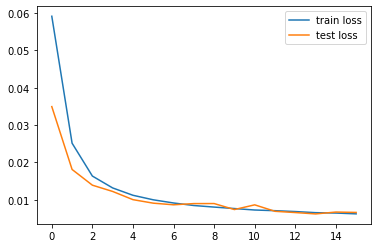

In [120]:
plt.plot(autoencoder.history.history['loss'], label='train loss')
plt.plot(autoencoder.history.history['val_loss'], label='test loss')
plt.legend()
plt.show();

In [121]:
idx = np.random.randint(len(X_test), size=100)
rec_X_test = autoencoder(X_test, training=False).numpy()

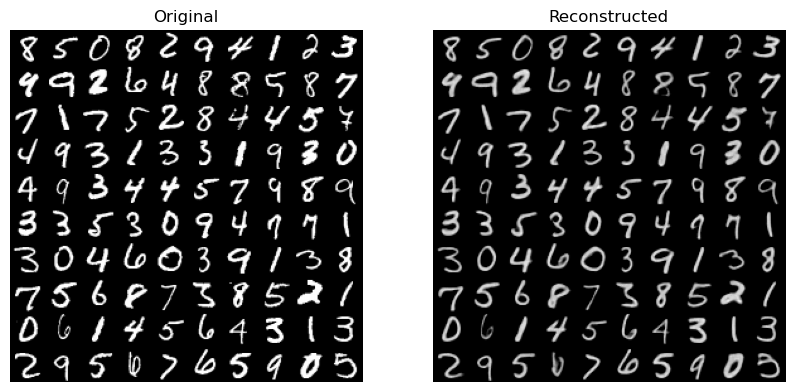

In [122]:
def plot100(imgs):
  """
  Takes an image of size (100, None, None) and draws it
  """
  plt.imshow(
      np.array(imgs).reshape(
          (10, 10) + imgs.shape[1:3]
      ).transpose(0, 2, 1, 3).reshape(np.array(imgs.shape[1:]) * 10),
      cmap = "gray"
  )
  plt.axis('off')

plt.figure(figsize=(10, 5), dpi=100)
plt.subplot(1, 2, 1)
plt.title("Original")
plot100(X_test[idx])
plt.subplot(1, 2, 2)
plt.title("Reconstructed")
plot100(rec_X_test[idx])

# Exercise: interpolating between bottleneck representations

Задача: пройти по латентному пространству от точки, соответсвующей ''5'' до точки ''1''.

Прохождение по прямой между точками $x_1$ и $x_2$ в любом метрическом пространстве можно параметризовать параметром $t$, принимающим значения от 0 до 1: $$x(t) = (1-t)*x_1 + t*x_2$$

In [123]:
digit_1 = 5
digit_2 = 1

# Let's take 10 images of digit_1 and digit_2:
digits_1 = X_test[y_test == digit_1][:10]
digits_2 = X_test[y_test == digit_2][:10]

# Calculate the encoded representations of these digits:
representation_1 = encoder(digits_1,training=False).numpy()
representation_2 = encoder(digits_2,training=False).numpy()

In [124]:
print(representation_1.shape)

(10, 32)


In [125]:
new_rep_1 = representation_1[None,:,:]+np.zeros((10,10,32))
new_rep_2 = representation_2[None,:,:]+np.zeros((10,10,32))

In [126]:
t = np.linspace(0,1,10)
print(t.shape)

(10,)


In [127]:
representation_mixed = new_rep_1*(1-t)[:,None,None] + new_rep_2*t[:,None,None]

In [128]:
print(representation_mixed.shape)

(10, 10, 32)


In [129]:
mixed_imgs = decoder(representation_mixed.reshape((100,32)),training = False).numpy()

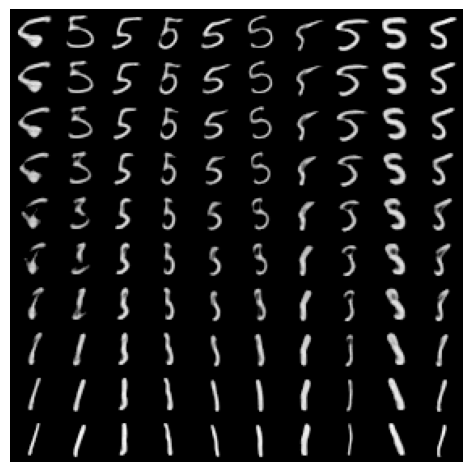

In [130]:
plt.figure(figsize=(6, 6), dpi=100)
plot100(mixed_imgs)

Красота!